# Imports

In [19]:
import numpy as np
import pandas as pd
import json
from scipy.optimize import curve_fit, brentq
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import uncertainties.unumpy as unp
import uncertainties as unc

# Functions

In [20]:
def exponential(x, a, b):
    return a * np.exp(b * x)

# Data

In [21]:
df_regions = pd.read_json('../pcm-dpc-COVID-19/dati-json/dpc-covid19-ita-regioni.json')

df_pop = pd.read_csv('dati_regioni.csv')

# How many days behind Lombardy?

## Lombardy data interpolation

In [22]:
df_lombardia = df_regions[df_regions.denominazione_regione == 'Lombardia']
pop_lombardia = df_pop[df_pop.denominazione_regione == 'Lombardia']['popolazione'].values[0]
y = df_lombardia.totale_casi.values
days = len(y)
x_lombardia = np.arange(days)
y_lombardia = y * 1e6 / pop_lombardia #total cases per million people
print(y_lombardia[0], y_lombardia[-1])

17.096440024197427 1456.0799413631867


## Plot

In [23]:
params = {'figure.figsize': (8.5, 5.5)}
plt.rcParams.update(params)

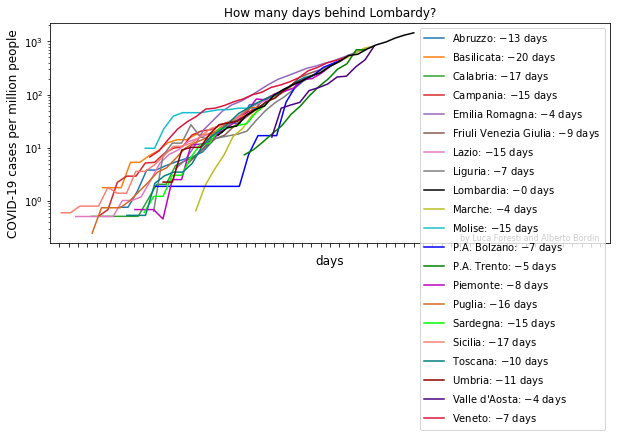

In [24]:
fig, ax = plt.subplots(constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    pop = df_pop[df_pop.denominazione_regione == den]['popolazione'].values[0]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 0]
    delta = days - len(y)
    y = y * 1e6 / pop #total cases per million people
    x = np.arange(delta, days)
    shift = 0
    if den != 'Lombardia':
        interpolated = interp1d(x_lombardia, y_lombardia - y[-1])
        x0 = brentq(interpolated, 0, 20)
        shift = days - 1 - x0
        #ax.plot(x0, y[-1], 'o', color=colors[i])
        label = '{}: $-${} days'.format(den, int(shift))
        ax.plot(x - shift, y, color=colors[i], label=label)
    else:
        label = '{}: $-${} days'.format(den, int(shift))
        ax.plot(x - shift, y, color=colors[i], label=label, zorder = 22)
    
ax.set_yscale('log')
ax.set_ylabel('COVID-19 cases per million people', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-18, 42)
xticks = np.arange(-17, 42)
ax.set_xticks(xticks)
ticklabels = ['' for x in range(len(xticks))]
ax.set_xticklabels(ticklabels)
ax.set_title('How many days behind Lombardy?', fontsize='large')
ax.legend(loc=1)
ax.text(26, 1.8e-1, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/regions_chasing_Lombardy.png', dpi = 300)

# Exponential fit italian regions

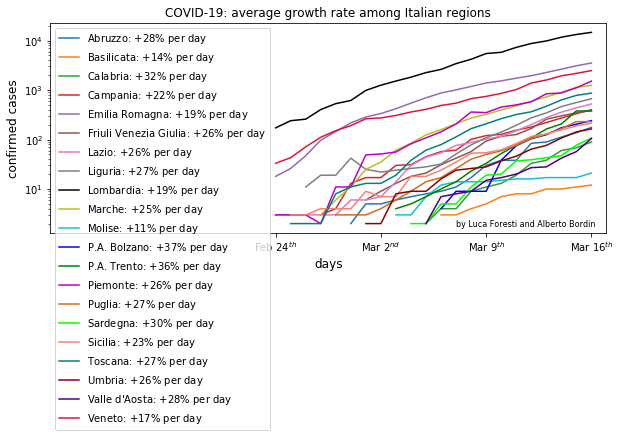

In [25]:
fig, ax = plt.subplots(constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 1]
    delta = days - len(y)
    x = np.arange(delta, days)
    popt, pcov = curve_fit(exponential, x, y, sigma=np.sqrt(y))
    a, b = unc.correlated_values(popt, pcov)
    slope = unc.nominal_value(b)
    std = unc.std_dev(b)
    
    label = '{}: $+${}% per day'.format(den, int(round(slope, 2)*100))
    #ax.plot(x, exponential(x, *popt), color=colors[i])
    ax.plot(x, y, color=colors[i], label=label)
    
ax.set_yscale('log')
ax.set_ylabel('confirmed cases', fontsize='large')
ax.set_xlabel('days', fontsize='large')
ax.set_xlim(-15, days)
xticks = np.arange(0, days, 7)
ax.set_xticks(xticks)
ticklabels = ['Feb 24$^{th}$', 'Mar 2$^{nd}$', 'Mar 9$^{th}$', 'Mar 16$^{th}$']
ax.set_xticklabels(ticklabels)
ax.set_title('COVID-19: average growth rate among Italian regions', fontsize='large')
ax.legend(loc=2)
ax.text(days - 10, 1.7, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/regions_rate.png', dpi = 300)

# Correlazione growth-rate e componenti-medi-famiglia

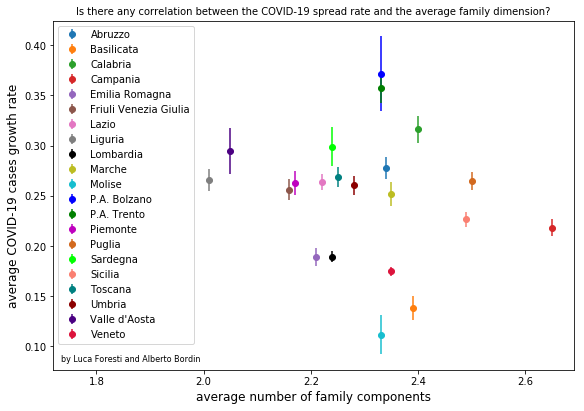

In [48]:
fig, ax = plt.subplots(figsize=(8,5.6), constrained_layout=True)

denominazioni = np.unique(df_regions.denominazione_regione.values)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'black', 'tab:olive',
          'tab:cyan', 'b', 'g', 'm', 'chocolate',
          'lime', 'salmon', 'teal', 'darkred', 'indigo',
          'crimson']

for i, den in enumerate(denominazioni):
    dfr = df_regions[df_regions.denominazione_regione == den]
    y = dfr.totale_casi.values
    days = len(y)
    y = y[y > 1]
    delta = days - len(y)
    x = np.arange(delta, days)
    popt, pcov = curve_fit(exponential, x, y, sigma=np.sqrt(y))
    a, b = unc.correlated_values(popt, pcov)
    slope = unc.nominal_value(b)
    std = unc.std_dev(b)
    
    componenti_famiglia = df_pop[df_pop.denominazione_regione == den]['componenti_medi_famiglia'].values[0]
    ax.errorbar(componenti_famiglia, slope, yerr=std, fmt='o', color=colors[i], label=den)
    
ax.set_ylabel('average COVID-19 cases growth rate', fontsize='large')
ax.set_xlabel('average number of family components', fontsize='large')
ax.set_xlim(1.72, 2.69)
ax.set_title('Is there any correlation between the COVID-19 spread rate and the average family dimension?', fontsize='medium')
ax.legend(loc=2)

ax.text(1.735, 0.085, r'by Luca Foresti and Alberto Bordin', fontsize=8)

fig.savefig('plot/correlation_rate-families.png', dpi = 300)